In [2]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import datetime
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool

import tensorflow as tf
import sklearn
import sklearn.metrics

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K

from keras.callbacks import TensorBoard

tf.__version__

'1.5.0'

In [3]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [4]:
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_" + readable_timestamp

In [5]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_blobs.pkl")
df_train = dfAll[(dfAll.userID != 1) | (dfAll.userID != 2)]
df_test = dfAll[(dfAll.userID == 1) | (dfAll.userID == 2)]

df_test = df_test.reset_index()
df_train = df_train.reset_index()
#Create InputMethod Column and fill it with Knuckel / Finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df_train['InputMethod'] = df_train.apply(f, axis=1)
df_test['InputMethod'] = df_test.apply(f, axis=1)
df_train2 = df_train[['Blobs', 'InputMethod']].copy()
df_test2 = df_test[['Blobs', 'InputMethod']].copy()

In [6]:
x_train = np.vstack(df_train2.Blobs)
x_test = np.vstack(df_test2.Blobs)
y_train = df_train2.InputMethod.values
y_test = df_test2.InputMethod.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [7]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = tf.keras.utils.to_categorical(df_train2.InputMethod, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(df_test2.InputMethod, num_classes)

Text(0.5,1,'Label for image 1 is: 0')

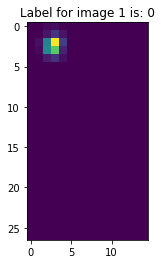

In [8]:
i = 1
plt.imshow(x_train[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y_train[i]))

In [9]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [10]:
y_test_one_hot.shape

(19074, 2)

In [12]:
########## HYPER PARAMETERS
batch_size = 200
epochs = 5000
#optimizer = tf.keras.optimizers.Adam()\n",
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)

########## HYPER PARAMETERS

########## MODEL ARCHITECTURE
model = tf.keras.Sequential()


model.add(tf.keras.layers.Conv2D(84, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1)))
model.add(tf.keras.layers.Conv2D(84, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Conv2D(42, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(42, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(400, activation=('relu'), use_bias=True))
model.add(tf.keras.layers.Dense(100, activation=('relu'), use_bias=True))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE

####TENSORBOARD
config = ""
#config += "batch_size: " + batch_size + " epochs: " + epochs
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
#### END TENSORBOARD


# Print summary
model.summary()

# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0, write_graph=True, write_images=True, update_freq = 'epoch')],
                    validation_data=(x_test, y_test_one_hot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 27, 15, 84)        840       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 15, 84)        63588     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 7, 84)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 7, 84)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 7, 42)         31794     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 7, 42)         15918     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 3, 42)          0         
__________

FailedPreconditionError: Attempting to use uninitialized value RMSprop_1/iterations
	 [[Node: RMSprop_1/iterations/read = Identity[T=DT_INT64, _class=["loc:@RMSprop_1/iterations"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](RMSprop_1/iterations)]]

Caused by op 'RMSprop_1/iterations/read', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-94899b6aab28>", line 5, in <module>
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/_impl/keras/optimizers.py", line 237, in __init__
    self.iterations = K.variable(0, dtype='int64', name='iterations')
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/_impl/keras/backend.py", line 582, in variable
    constraint=constraint)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 229, in __init__
    constraint=constraint)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 376, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py", line 127, in identity
    return gen_array_ops.identity(input, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2134, in identity
    "Identity", input=input, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value RMSprop_1/iterations
	 [[Node: RMSprop_1/iterations/read = Identity[T=DT_INT64, _class=["loc:@RMSprop_1/iterations"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](RMSprop_1/iterations)]]


In [49]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))


 Summary of the precision, recall, F1 score for each class:
             precision    recall  f1-score   support

          0       0.89      0.85      0.87      3248
          1       0.91      0.93      0.92      4956

avg / total       0.90      0.90      0.90      8204


 Confusion matrix: 
[[2768  480]
 [ 336 4620]]


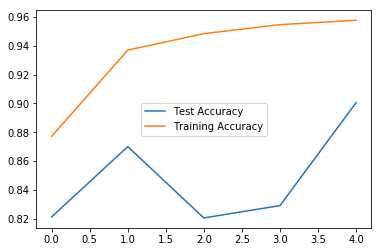

In [50]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()

In [51]:
# save model
model.save("myModel.h5")